In [13]:
import numpy as np
import math
from Crypto.Util.number import getPrime, inverse, bytes_to_long, long_to_bytes
import random

In [14]:
def gcd(a, b):
    if b == 0:
        return a
    else:
        return gcd(b, a%b)

# Digital Signatures

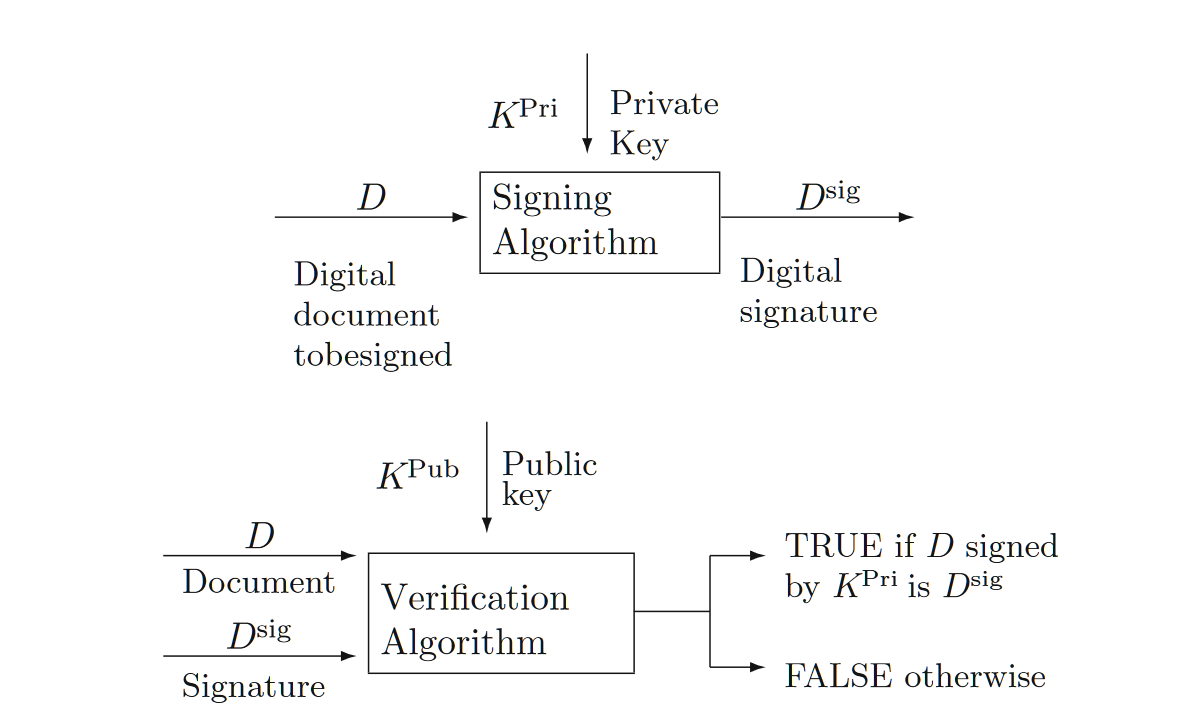

**Components**:
* $K^{Pri}$ = A private signing key.
* $K^{PubA}$ =  public verification key.
* Sign = A signing algorithm that takes as input a digital document $D$ and a private key $K^{Pri}$ and returns a signature $D^{sig}$ for $D$.
* Verify = A verification algorithm that takes as input a digital document $D$, a signature $D^{sig}$, and a public key $K^{Pub}$ The algorithm returns *True* if $D^{sig}$ is a signature for $D$ associated to the private key $K^{Pri}$,and otherwise it returns *False*.

**Conditions**  
• Given $K^{Pub}$, an attacker cannot feasibly determine $K^{Pri}$, nor can she determine any other private key that produces the same signatures as $K^{Pri}$.

• Given $K^{Pub}$ and a list of signed documents $D_1, . . . , D_n$ with their signatures $D^{sig}_1 , . . . , D_n^{sig}$, an attacker cannot feasibly determine a valid signature on any document $D$ that is not in the list $D_1, . . . , D_n$.




## RSA Digital Signature

Key creation:
* Choose secret primes $p$ and$q$
* Choose verification exponent $e$ with $\gcd(e,(p−1)(q−1)) = 1$
*  Publish $N=pq$ and $e$.

Signing:
* Compute $d$ satisfying $de≡1(mod(p−1)(q−1))$
* Sign document D by computing $S≡D^d(modN)$
* Return S

Verification:
* $D \equiv S^e mod \ N$ 

*Proof*:  
$S^e≡D^{de}≡D(modN)$

In [15]:
def rsa_ds_key_creation():
    p = getPrime(128)
    q = getPrime(128)
    N = p * q
    while True:
        e = random.randint(N//4,N-1)
        if(gcd(e, (p-1)*(q-1)) == 1):
            break
    return (p, q), (N, e)


In [16]:
def rsa_ds_sign(p, q, D):
    d = inverse(e, (p-1)*(q-1))
    S = pow(D, d, N)
    return S

In [17]:
def rsa_ds_verif(S, e, D):
    return pow(S, e, N) == D

In [18]:
D = 1000

In [19]:
(p, q), (N, e) = rsa_ds_key_creation()

In [20]:
S = rsa_ds_sign(p, q, D)

In [21]:
rsa_ds_verif(S, e, D)

True

## Elgamal

Public parameter creation:
* A trusted party chooses and publishes a large prime $p$ and primitive root $g$ modulo $p$

Key creation:
* Choose secret signing key $1≤a≤p−1$
* Compute $A=g^a(mod \ p)$
* Publish the verification key $A$

Signing
* Choose document $D \ mod \ p$
* Choose random element $1<k<p$ satisfying $\gcd(k,p−1) = 1$
* Compute signature  
$S_1≡g^k(mod \ p)$  
$S2≡(D-aS_1)k^{-1} (mod \ p−1)$.

Verification
* Compute $A^{S_1}S_1^{S_2} \ mod \ p$
* Verify that it is equal to $g^D \ mod \ p$.

*Proof*:  
$A^{S_1}·S_1^{S_2} ≡ g^{aS_1}·g^{kS_2} ≡ g^{aS_1+kS_2} ≡ g^{aS_1+k(D-aS_1)k^{-1}} ≡ g^{aS_1+(D-aS_1)} ≡ g^D \ (mod \ p)$

In [22]:
def elgamal_ds_key_creation():
    p = getPrime(128)
    g = 2 # or any other primitive root
    a = random.randint(2, p)
    A = pow(g, a, p)
    return a, (p, g, A)

def elgamal_ds_sign(D, a, g, p):
    while True:
        k = random.randint(2, p)
        if(gcd(k, p-1) == 1):
            break
    S_1 = pow(g, k, p)
    S_2 = (D - a * S_1) * inverse(k, p-1) % (p-1)
    return S_1, S_2

def elgamal_ds_verif(S_1, S_2, A, g, p, D):

    return pow(A, S_1, p) * pow(S_1, S_2, p) % p == pow(g, D, p)

In [23]:
D = 1000

In [24]:
a, (p, g, A) = elgamal_ds_key_creation()

In [25]:
S_1, S_2 = elgamal_ds_sign(D, a, g, p)

In [26]:
elgamal_ds_verif(S_1, S_2, A, g, p, D)

True

## DSA

Significantly shortens the signature by working in a subgroup of $\mathbb{F}^*_p$ of prime order $q$. The underlying assumption is that using the index calculus to solve the discrete logarithm problem in the subgroup is no easier than solving it in $\mathbb{F}^*_p$.

Public parameter creation:
* A trusted party chooses and publishes large primes $p$ and $q$ satisfying $p≡1(mod \ q)$ and an element $g$ of order $q$ modulo $p$

Key creation
* Choose secret signing key $1≤a≤q−1$
* Compute $A=g^a(mod \ p)$
& Publish the verification key $A$  

Signing
* Choose document $D \ mod \ q$
& Choose random element $1<k<q$
* Compute signature  
$S_1≡(g^k \ mod \ p) mod \ q$  
$S_2≡(D+aS_1)k^{−1}(mod \ q)$

Verification
* Compute   
$V_1≡DS_2^{-1} (mod \ q)$  
$V_2≡S_1S_2^{-1}(mod \ q)$
* Verify $(g^{V_1}A^{V_2} \ mod \ p) \ mod \ q=S_1$

In [55]:
def DSA_key_creation(p, q, g):
    
    a = 242
    a = random.randint(2, q-1)
    A = pow(g, a, p)
    return a, A

def DSA_sign(D, a, g, p, q):
    k = 427
    k = random.randint(2, q)
    S_1 = pow(g, k, p) % q
    S_2 = ((D + a * S_1) * inverse(k, q)) % q
    return S_1, S_2

def DSA_verif(S_1, S_2, A, g, p, q, D):
    V_1 = (D*inverse(S_2, q)) % q
    V_2 = (S_1 * inverse(S_2, q)) % q
    return pow(g, V_1, p) * pow(A, V_2, p) % p % q == S_1

In [68]:
p = 48731
q = 443
g = 5260 # or any other primitive root

In [69]:
D = 343

In [70]:
a, A = DSA_key_creation(p, q, g)
A

4541

In [71]:
S_1, S_2 = DSA_sign(D, a, g, p, q)

In [72]:
S_1, S_2

(226, 76)

In [73]:
DSA_verif(S_1, S_2, A, g, p, q, D)

True